In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load model output of sea surface temperature (SST) from netCDF files
datapath = '/mnt/disk2/data/ESM2G/'
data  = xr.open_dataset(datapath + 'tos_Omon_GFDL-ESM2G_historical_r1i1p1_200101-200512.nc')
tos = data.tos.load()
ntime,nlat,nlon = tos.shape

In [3]:
# Calculate monthly averages
monthly_average = np.zeros((12,nlat,nlon))
nyears = ntime/12.
for jtime in range(0,ntime):
    current_month = np.mod(jtime,12) # Keep track of which month we're in
    monthly_average[current_month,:,:] = tos[jtime,:,:] + monthly_average[current_month,:,:]
monthly_average[:,:,:] = monthly_average[:,:,:]/nyears

In [4]:
# Calculate monthly anomalies by subtracting the monthly climatology
tos_anomaly = np.zeros((ntime,nlat,nlon))
for jtime in range(0,ntime):
    current_month = np.mod(jtime,12) # Keep track of which month we're in
    tos_anomaly[jtime,:,:] = tos[jtime,:,:] - monthly_average[current_month,:,:]

In [6]:
# Calculate the El-Nino Southern Oscillation (ENSO) Index from the Nino 3.4 region
nino_minlat = -5  ; nino_maxlat = 5
nino_minlon = -170 ; nino_maxlon = -120
nino_index = np.zeros((ntime,1))
total_area = 0
for jlat in range(0,nlat):
    if (np.mod(jlat,10)==0):
        print(jlat)
    for jlon in range(0,nlon):
        inregion = ( (data.lat[jlat,jlon] >= nino_minlat and data.lat[jlat,jlon] <= nino_maxlat) and 
                     (data.lon[jlat,jlon] >= nino_minlon and data.lon[jlat,jlon] <= nino_maxlon) )
        if (inregion):  
            # This should be an area-weighted average, but for simplicity 
            # we do a naive average based on the total number of points
            total_area = total_area + 1
            for jtime in range(0,ntime):
                nino_index[jtime] = nino_index[jtime] + np.array(tos_anomaly[jtime,jlat,jlon])
nino_index[:] = nino_index[:] / total_area

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [9]:
# Calculate the covariance between the ENSO index and sea surface temperatures
nino_sst_covariance = np.zeros((nlat,nlon))
for jtime in range(0,ntime):
    for jlat in range(0,nlat):
        for jlon in range(0,nlon):
            nino_sst_covariance[jlat,jlon] = (nino_sst_covariance[jlat,jlon] + 
                                              tos_anomaly[jtime,jlat,jlon]*nino_index[jtime])
nino_sst_covariance = nino_sst_covariance/(ntime - 1)
            

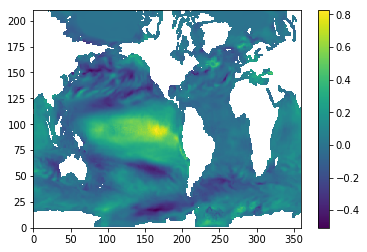

In [10]:
plt.pcolormesh(nino_sst_covariance); plt.colorbar(); plt.show()